## Importing the libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the dataset

In [50]:
dataset = pd.read_csv('graduation_success_data.csv', sep=';')
X = dataset.drop(columns='Target')
y = dataset['Target']

## Data exploration

### Detailed dataset explanation:
##### https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

In [51]:
dataset.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [52]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

### Looking up number of rows with at least 1 missing value

In [53]:
dataset.isna().any().sum()
# The dataset doesn't have missing values 👍

0

## Splitting the dataset into the Training set and Test set

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Encoding categorical data

### Sorting columns by their datatypes

In [55]:
numeric_cols = [
    'Application order', 'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP'
    ]

binary_categorical_cols = ['Daytime/evening attendance\t', 'Displaced', 'Educational special needs', 'Debtor',
                           'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']

multiclass_categorical_cols = X.drop(columns=numeric_cols).columns.difference(binary_categorical_cols)

### Encoding the dependent variable

In [56]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), name = 'Target')

### Encoding multiclass categorical features and scaling numerical features

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

ct_linear = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=None), multiclass_categorical_cols), # drop=None, since unseen classes might meet in the test set.
    ('scaler', StandardScaler(), numeric_cols)
    ], remainder='passthrough')

ct_tree = ColumnTransformer(
    transformers=[
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            list(multiclass_categorical_cols) + binary_categorical_cols,
        ),
    ],
    remainder="passthrough",
)

ct_prob = ColumnTransformer(
    transformers=[
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            list(multiclass_categorical_cols) + binary_categorical_cols,
        ),
        ("scale", StandardScaler(), numeric_cols),
    ],
    remainder="passthrough",
)

## Trying different models

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

pipeline = Pipeline([
    ('preprocessing', 'passthrough'),
    ('classifier', DummyClassifier())
])

param_grid = [
    {
        "preprocessing": [ct_linear],
        "classifier": [
            LogisticRegressionCV(max_iter=1000, random_state=23),
            SVC(kernel="linear"),
            SVC(kernel="rbf"),
        ],
    },
    {
        "preprocessing": [ct_tree],
        "classifier": [
            DecisionTreeClassifier(random_state=23),
            RandomForestClassifier(random_state=23),
            GradientBoostingClassifier(random_state=23),
        ],
    },
    {
        "preprocessing": [ct_prob],
        "classifier": [
            GaussianNB(),
        ],
    },  
]

pipeline = GridSearchCV(pipeline, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
pipeline.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('classifier', DummyClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegressionCV(max_iter=1000,
                                                              random_state=23),
                                         SVC(kernel='linear'), SVC()],
                          'preprocessing': [ColumnTransformer(remainder='passthrough',
                                                              transformers=[('encoder',
                                                                             OneHotEncoder(handle_unknown='ignore',...
                                                                              'evaluations)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(credited)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(enrolled)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(evaluations)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(approved)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(grade)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(without '
                                                                              'evaluations)',
                                                                              'Unemployment '
                                                                              'rate',
                                                                              'Inflation '
                                                                              'rate',
                                                                              'GDP'])])]}],
     

### Exploring the best model

In [59]:
best_model = pipeline.best_estimator_.named_steps['classifier']
model_name = type(best_model).__name__

hyperparams = ""

if model_name == "SVC":
    hyperparams = f"(kernel='{best_model.kernel}')"
elif model_name == "RandomForestClassifier":
    hyperparams = f"(n_estimators={best_model.n_estimators}, max_depth={best_model.max_depth})"
elif model_name == "DecisionTreeClassifier":
    hyperparams = f"(max_depth={best_model.max_depth})"
elif model_name == "LogisticRegressionCV":
    hyperparams = f"(Cs={best_model.Cs})"
elif model_name == "GradientBoostingClassifier":
    hyperparams = f"(learning_rate={best_model.learning_rate}, max_depth={best_model.max_depth})"

print(
    f"The top-performing model is {model_name} with hyperparameters:\n{hyperparams}\nwith an accuracy of {pipeline.best_score_:.4f}."
)

The top-performing model is SVC with hyperparameters:
(kernel='linear')
with an accuracy of 0.6951.


## Visualization of performance for different models

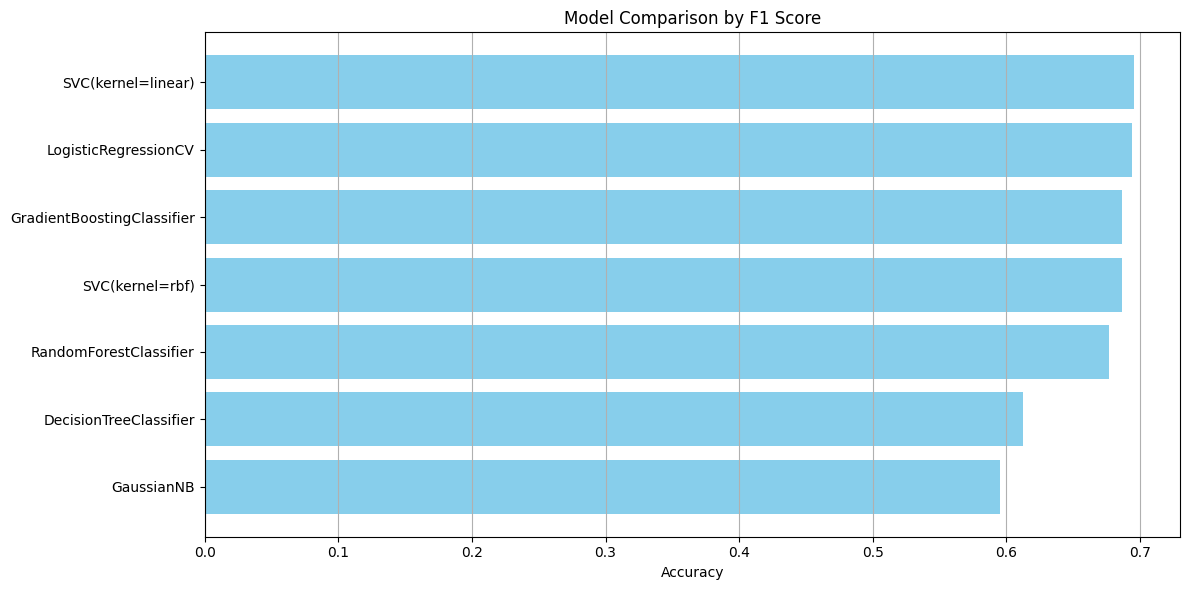

In [60]:
results = pipeline.cv_results_

mean_scores = results['mean_test_score']
params = results['params']

model_labels = []
for p in params:
    model = type(p['classifier']).__name__
    label = None
    if model == "SVC":
        label =f"{model}(kernel={p['classifier'].kernel})"
    else:
        label = f"{model}"
    model_labels.append(label)

sorted_indices = np.argsort(mean_scores)[::-1]
sorted_scores = mean_scores[sorted_indices]
sorted_labels = np.array(model_labels)[sorted_indices]

plt.figure(figsize=(12, 6))
plt.barh(sorted_labels, sorted_scores, color='skyblue')
plt.title("Model Comparison by F1 Score")
plt.xlabel("Accuracy")
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()